# **MRMS/CCRFCD** Rain-Gauge Data Analysis
---

- Time Period: [2021.01.01-2025.07.25]
- **`TODO`**: describe data-collection methodology in detail
- **`TODO`**: explain format of master-dataframe

### 0. Imports & Magic Constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime


ALL_EVENTS_DF = "/playpen/mufan/levi/tianlong-chen-lab/nws-lv-precip-forecasting/ccrfcd-gauge-grids/data/events/2021-01-01_2025-07-25_all_events.csv"

### 1. Whole-Dataset Analysis

In [2]:
df = pd.read_csv(ALL_EVENTS_DF)

# NOTE: filter out extremes
# occasional outlier rain-gauge values appear in the CCRFCD database; CCRFCD does not perform any QC
mask = (df['delta_qpe'] > df['delta_qpe'].quantile(0.001)) & (df['delta_qpe'] < df['delta_qpe'].quantile(0.999))
df   = df.loc[mask].copy()
df.head()

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,cum_gauge_qpe,cum_mrms_qpe
0,2021-01-23 23:00:00,2021-01-24 00:00:00,4709,35.925000,244.883000,0.00,0.003937,-0.003937,0.00,0.003937
1,2021-01-23 23:00:00,2021-01-24 00:00:00,4564,36.028250,244.996361,0.04,0.000000,0.040000,0.04,0.000000
2,2021-01-23 23:00:00,2021-01-24 00:00:00,4779,36.021861,245.041250,0.04,0.000000,0.040000,0.04,0.000000
3,2021-01-23 23:00:00,2021-01-24 00:00:00,4984,35.729250,244.811972,0.00,0.011811,-0.011811,0.00,0.011811
4,2021-01-23 23:00:00,2021-01-24 00:00:00,4724,35.939417,244.922250,0.00,0.015748,-0.015748,0.00,0.015748


In [3]:
print(f"Total number of data points: {len(df)}")
print(f"Number of unique gauges: {len(set(df['station_id']))}")

Total number of data points: 2337407
Number of unique gauges: 223


#### 1.1. Distribution of Events by Date

In [ ]:
dts        = [datetime.strptime(s, "%Y-%m-%d %H:%M:%S") for s in df['start_time']]
unique_dts = list(set(dts))

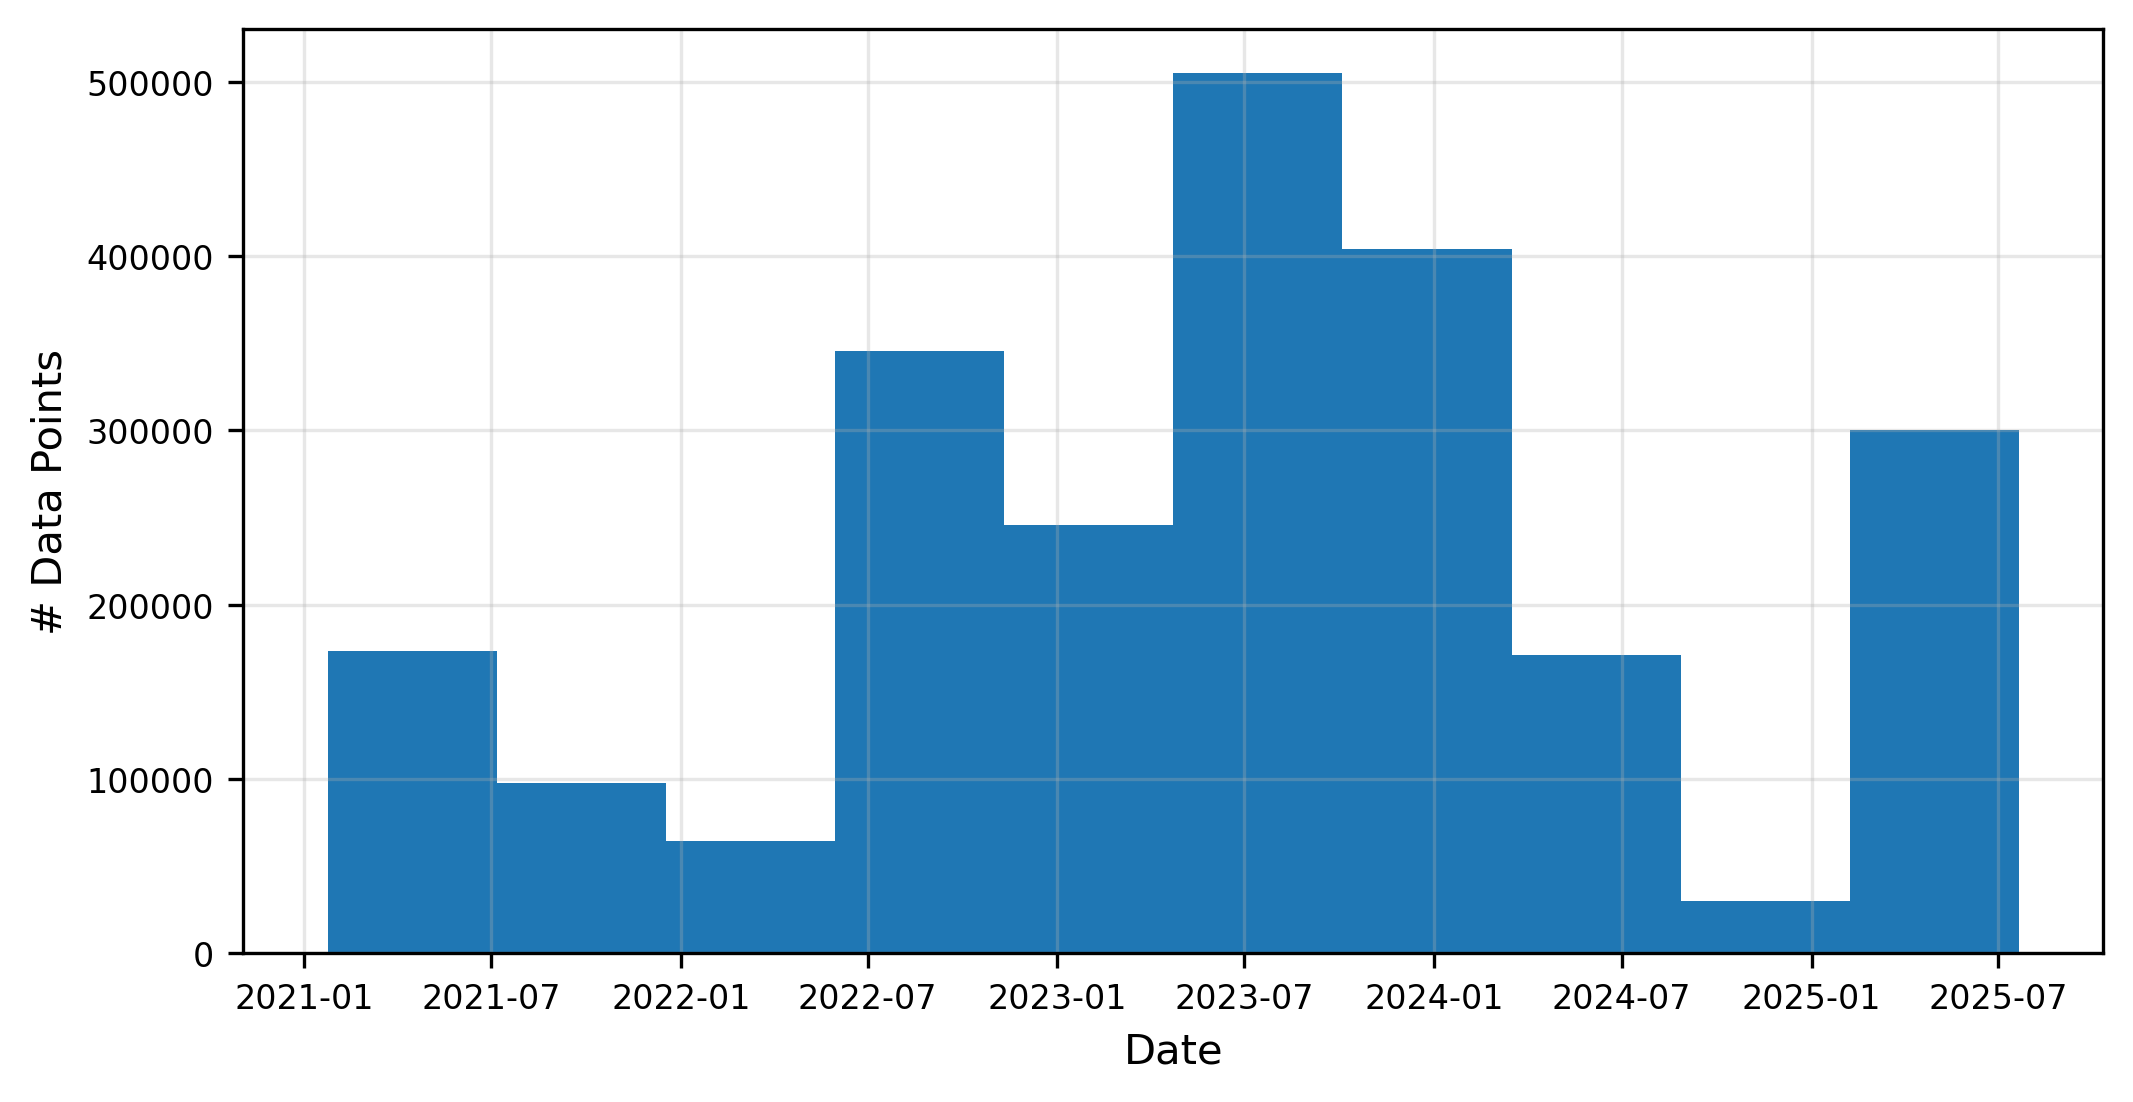

In [133]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
ax.hist(dts)
ax.grid(alpha=0.3)

plt.xlabel("Date")
plt.xticks(fontsize=8)
plt.ylabel("# Data Points")
plt.yticks(fontsize=8)
plt.show()

#### 1.2. Distribution of `mrms_qpe` by Seasonality

In [109]:
df["start_time"] = pd.to_datetime(df["start_time"])
months = df["start_time"].dt.month

all_values = []
for i in range(1, 13):
    mask       = months.between(i, i)
    delta_qpes = df.loc[mask, "mrms_qpe"].tolist()
    all_values.append(delta_qpes)

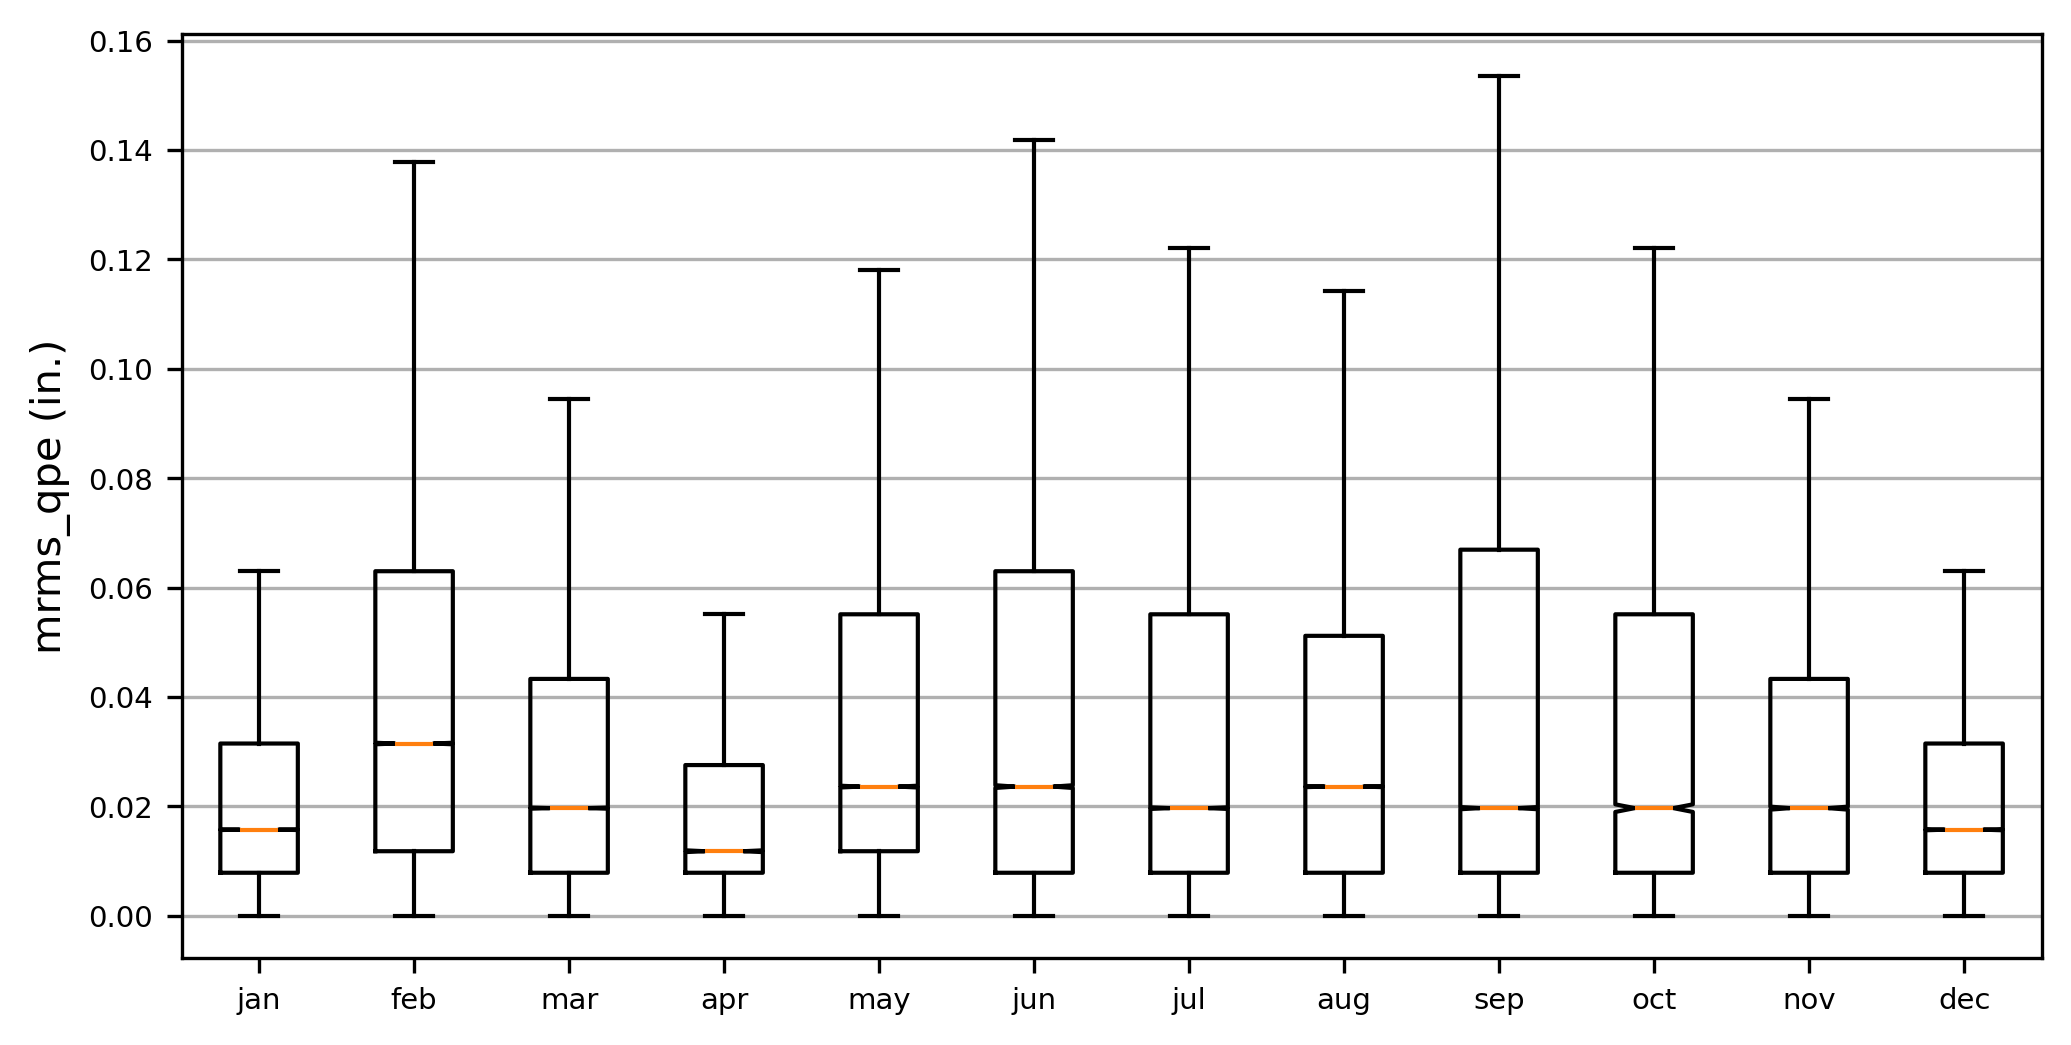

In [116]:
fig, axs = plt.subplots(figsize=(8, 4), dpi=300)
axs.boxplot(
    all_values,
    notch=True,
    showfliers=False,
    )

axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(12)],
                  labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel("mrms_qpe (in.)")
plt.show()

### 2. Per-Event Analysis

#### 2.1. Constructing Synthetic Rainfall "Events"

- As collected, our raw data do not have any meaningful metadata attached to delinate unique rain fall events. In the following section, we create synthetic "events" so that we can analyize the performance of rain-gauges over time.

In [ ]:
# cummulative sum of all MRMS values at all gauges for each unique timestep
grouped_df   = df[['start_time', 'mrms_qpe']].groupby('start_time').sum().copy()
cum_mrms_qpe = grouped_df['mrms_qpe']

series = np.asarray(list(cum_mrms_qpe))
x      = np.arange(series.size)
p50    = np.percentile(series, 50)
p90    = np.percentile(series, 90)


def segment_rainfall_events(
        precip_array, 
        interval_minutes=2, 
        wet_period_mins=60, 
        dry_period_mins=120, 
        rain_threshold=p50,
    ) -> pd.DataFrame:
    """
    Returns:
        pd.DataFrame: Columns include 'precipitation' and 'is_event' (bool).
    """
    precip_series = pd.Series(precip_array)
    is_rain = (precip_series > rain_threshold).astype(int)

    wet_period_intervals = wet_period_mins // interval_minutes
    dry_period_intervals = dry_period_mins // interval_minutes
    
    rolling_wet = is_rain.rolling(window=wet_period_intervals, min_periods=wet_period_intervals).sum()
    valid_wet_start = (rolling_wet == wet_period_intervals)

    rolling_dry = is_rain.rolling(window=dry_period_intervals, min_periods=dry_period_intervals).sum()
    valid_dry_end = (rolling_dry == 0)

    is_event = np.zeros_like(is_rain, dtype=bool)

    in_event = False
    start_idx = 0

    for i in range(len(is_rain)):
        if not in_event:

            # Wait until a valid wet period starts
            if valid_wet_start.iloc[i]:
                in_event = True
                start_idx = i - wet_period_intervals + 1  # start of rain
        else:
            
            # If inside an event, check for a valid dry period to end the event
            if valid_dry_end.iloc[i]:
                end_idx = i - dry_period_intervals + 1
                is_event[start_idx:end_idx] = True
                in_event = False

    if in_event:
        is_event[start_idx:] = True

    return pd.DataFrame({
        'precipitation': precip_series,
        'is_event': is_event
    })


rainfall_events = segment_rainfall_events(series)

In [140]:
grouped_df['is_event'] = list(rainfall_events['is_event'])

curr_id   = -1
flag      = False
event_ids = []

for is_event in list(grouped_df['is_event']):
    
    if is_event == True:
        if flag == False:
            curr_id += 1
            flag = True
    else:
        flag = False
        
    event_ids.append(curr_id if is_event else np.nan)

grouped_df['event_id'] = event_ids
event_ids_mapped       = {dt: event_id for dt, event_id in zip(list(grouped_df.index), list(grouped_df['event_id']))}
event_ids_mapped

{'2021-01-23 23:00:00': nan,
 '2021-01-23 23:02:00': nan,
 '2021-01-23 23:04:00': nan,
 '2021-01-23 23:06:00': nan,
 '2021-01-23 23:08:00': nan,
 '2021-01-23 23:10:00': nan,
 '2021-01-23 23:12:00': nan,
 '2021-01-23 23:14:00': nan,
 '2021-01-23 23:16:00': nan,
 '2021-01-23 23:18:00': nan,
 '2021-01-23 23:20:00': nan,
 '2021-01-23 23:22:00': nan,
 '2021-01-23 23:24:00': nan,
 '2021-01-23 23:26:00': nan,
 '2021-01-23 23:28:00': nan,
 '2021-01-23 23:30:00': nan,
 '2021-01-23 23:32:00': nan,
 '2021-01-23 23:34:00': nan,
 '2021-01-23 23:36:00': nan,
 '2021-01-23 23:38:00': nan,
 '2021-01-23 23:40:00': nan,
 '2021-01-23 23:42:00': nan,
 '2021-01-23 23:44:00': nan,
 '2021-01-23 23:46:00': nan,
 '2021-01-23 23:48:00': 0.0,
 '2021-01-23 23:50:00': 0.0,
 '2021-01-23 23:52:00': 0.0,
 '2021-01-23 23:54:00': 0.0,
 '2021-01-23 23:56:00': 0.0,
 '2021-01-23 23:58:00': 0.0,
 '2021-01-24 00:00:00': 0.0,
 '2021-01-24 00:02:00': 0.0,
 '2021-01-24 00:04:00': 0.0,
 '2021-01-24 00:06:00': 0.0,
 '2021-01-24 0

In [144]:
event_ids      = [event_ids_mapped[k] for k in list(df['start_time'])]
df['event_id'] = event_ids
df.loc[df['event_id'] > 0.0]

,start_time,end_time,station_id,lat,lon,gauge_qpe,mrms_qpe,delta_qpe,cum_gauge_qpe,cum_mrms_qpe,event_id
2562,2021-01-25 23:00:00,2021-01-26 00:00:00,4504,36.225833,244.673917,0.00,0.062992,-0.062992,0.00,0.062992,1.0
2563,2021-01-25 23:00:00,2021-01-26 00:00:00,3844,36.239361,244.441083,0.00,0.023622,-0.023622,0.00,0.748032,1.0
2564,2021-01-25 23:00:00,2021-01-26 00:00:00,4074,36.195833,244.901389,0.00,0.007874,-0.007874,0.00,0.212598,1.0
2565,2021-01-25 23:00:00,2021-01-26 00:00:00,4384,36.130694,244.835528,0.00,0.011811,-0.011811,0.00,0.011811,1.0
2566,2021-01-25 23:00:00,2021-01-26 00:00:00,4289,36.155764,244.837406,0.00,0.011811,-0.011811,0.00,0.110236,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2340950,2025-07-18 22:22:00,2025-07-18 23:22:00,3044,36.758417,245.551000,0.00,0.003937,-0.003937,24.60,435.771659,174.0
2340951,2025-07-18 22:22:00,2025-07-18 23:22:00,3274,36.595083,245.467167,0.00,0.137795,-0.137795,28.50,503.448826,174.0
2340952,2025-07-18 22:22:00,2025-07-18 23:22:00,3301,35.995444,245.136194,0.01,0.000000,0.010000,87.96,535.342526,174.0
2340953,2025-07-18 22:22:00,2025-07-18 23:22:00,4014,36.430806,244.714389,0.00,0.007874,-0.007874,10.50,519.192920,174.0


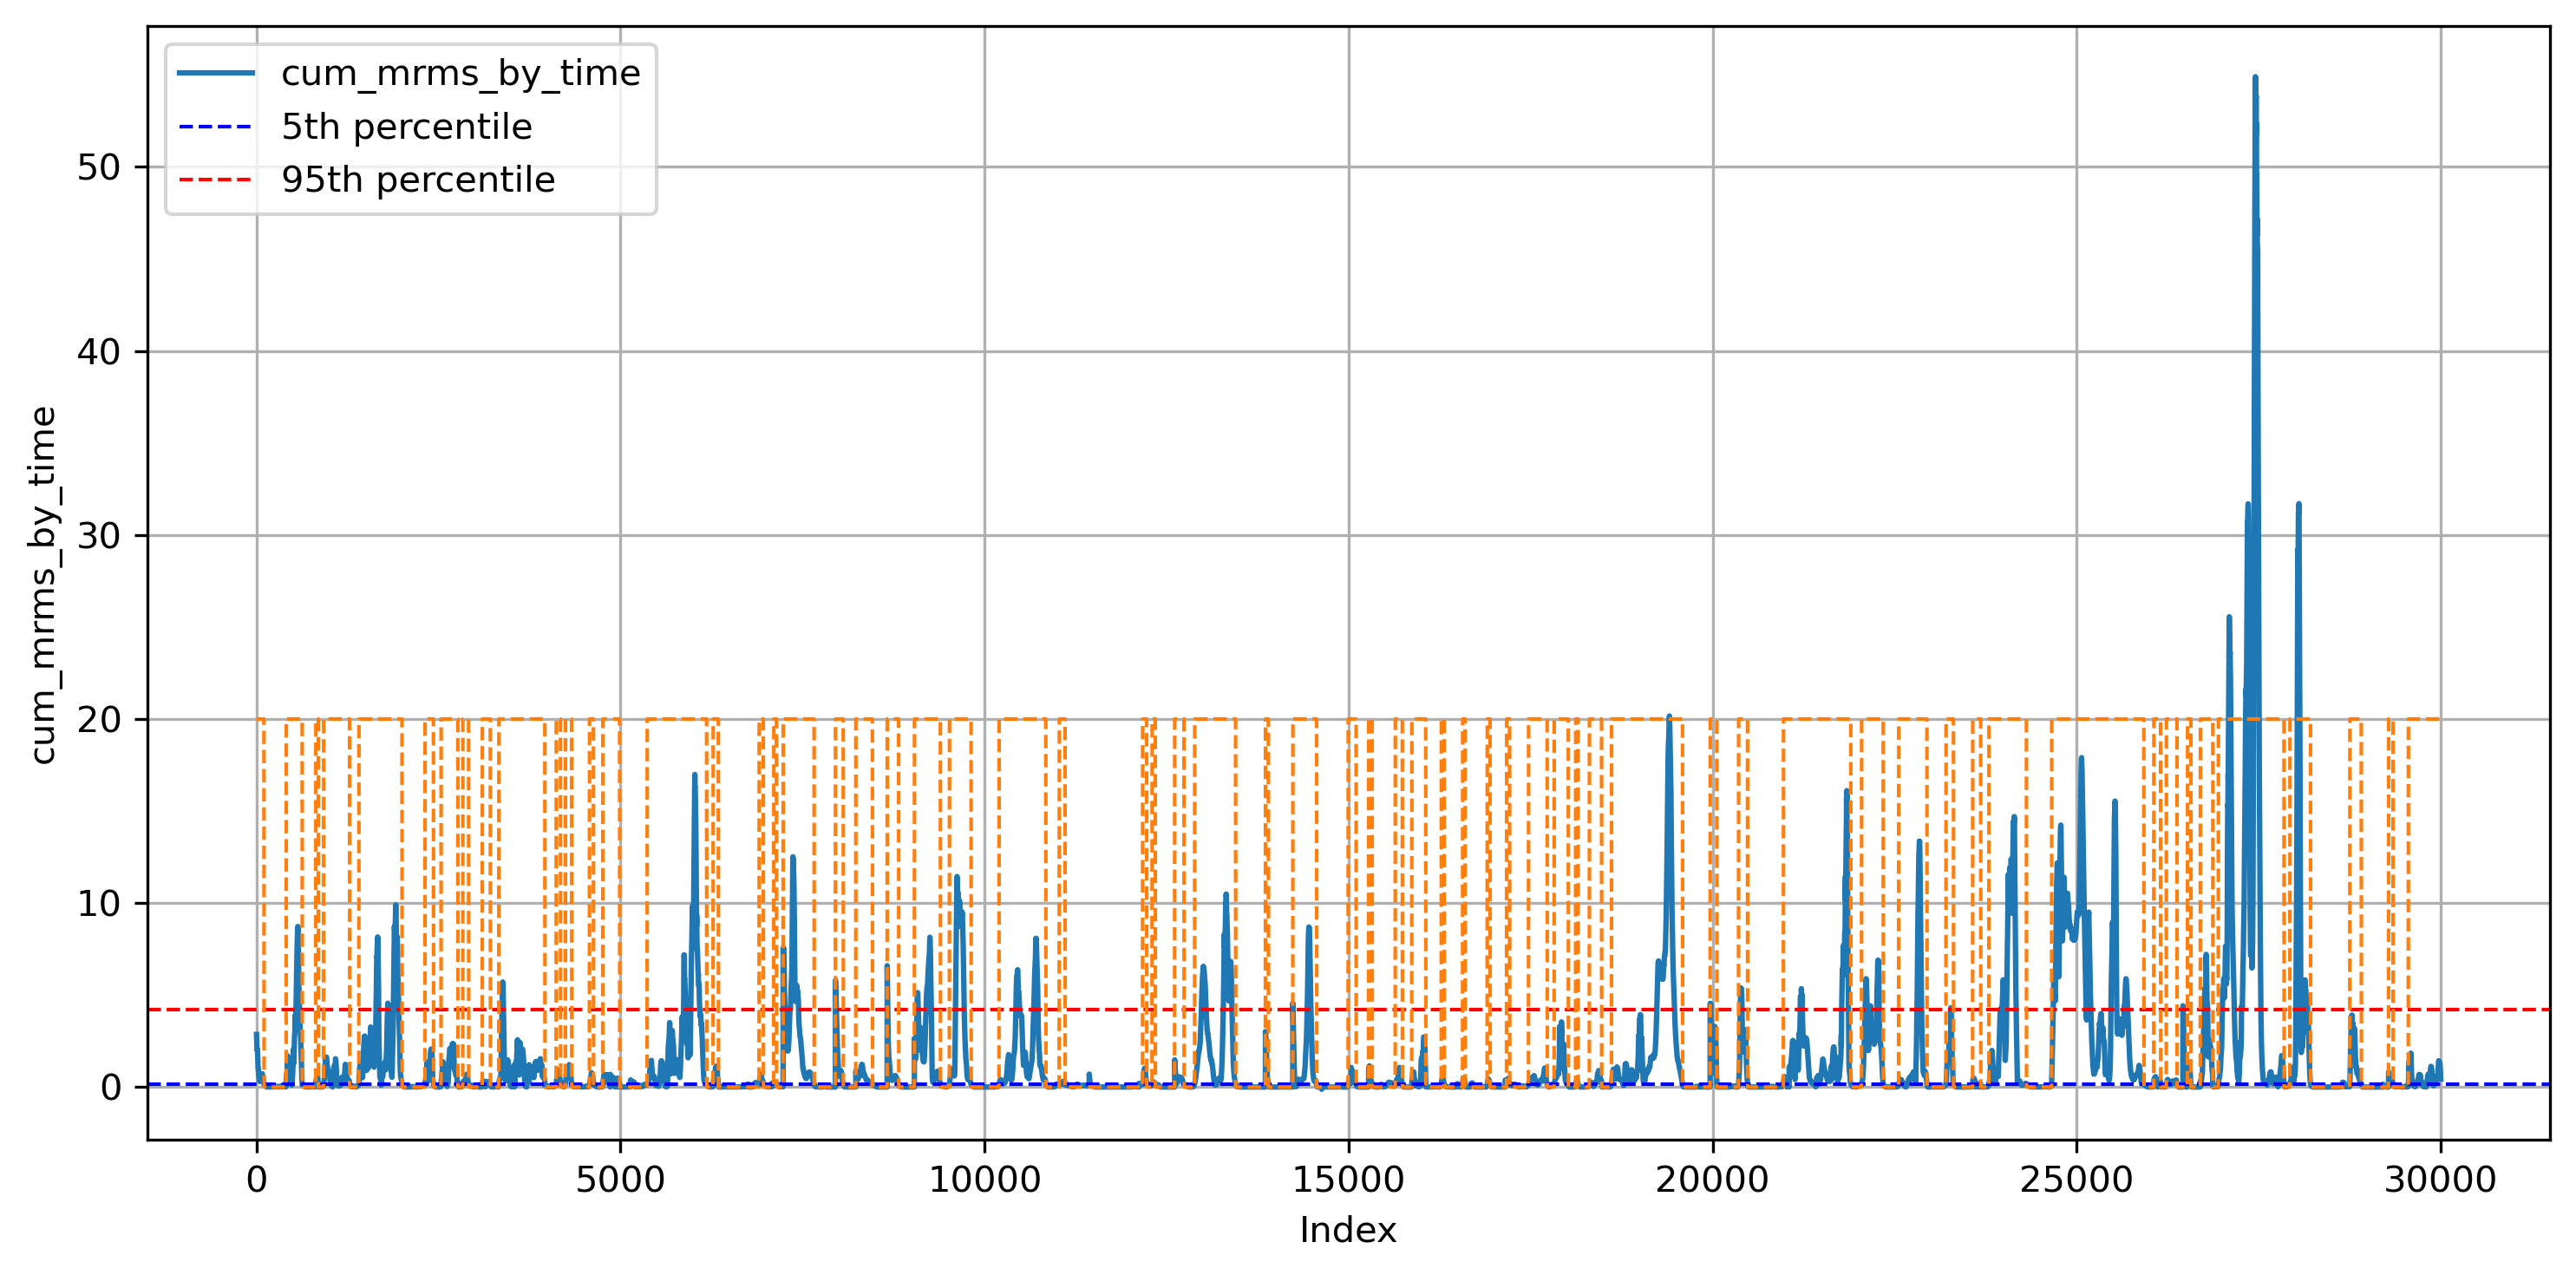

In [113]:
def crossings(y, thresh):
    """Return indices where the series crosses a horizontal threshold."""
    diff = y - thresh
    cross_idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0] + 1
    return cross_idx


low_hits  = crossings(series, p5)
high_hits = crossings(series, p95)

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.plot(x, series, label='cum_mrms_by_time')

# horizontal percentile lines
ax.axhline(p5,  color='blue',  linestyle='--',  linewidth=1, label='5th percentile')
ax.axhline(p95, color='red',   linestyle='--',  linewidth=1, label='95th percentile')

seen_events = set()
# for i, event in enumerate(rainfall_events):
#     if event not in seen_events:
#         color = "blue" if event != 0 else "red"
#         ax.axvline(i, linestyle='--',  color=color, linewidth=1, label=f"Rain Event: {event}")
#         seen_events.add(event)

# # intersection points
# ax.scatter(low_hits,  series[low_hits],  color='purple', marker='o',  zorder=3, label='Cross 5 %', s=10)
# ax.scatter(high_hits, series[high_hits], color='red',    marker='o',  zorder=3, label='Cross 95 %',s=10)

ax.plot(rainfall_events['is_event'] * 20, linestyle='--', linewidth=1.0)

ax.set_xlabel('Index')
ax.set_ylabel('cum_mrms_by_time')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

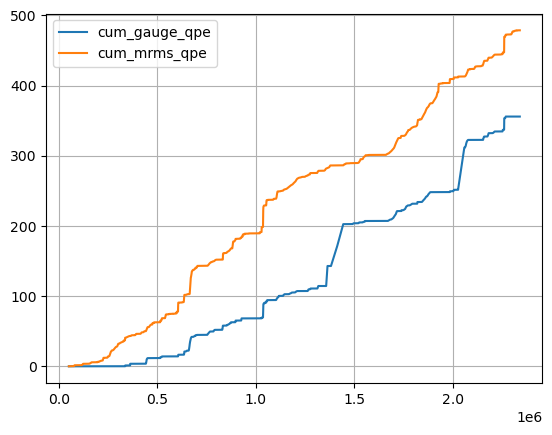

In [114]:
station_four  = df.loc[df['station_id'] == 4]
cum_gauge_qpe = station_four['cum_gauge_qpe']
cum_mrms_qpe  = station_four['cum_mrms_qpe']

plt.plot(cum_gauge_qpe, label="cum_gauge_qpe")
plt.plot(cum_mrms_qpe,  label="cum_mrms_qpe")
plt.grid()
plt.legend()
plt.show();

In [115]:
segment_rainfall_events(cum_mrms_qpe)

,precipitation,is_event
50696,0.003937,False
50890,0.007874,False
50950,0.011811,False
51193,0.015748,False
51426,0.019685,False
...,...,...
2339224,478.685044,True
2339252,478.688981,True
2339319,478.692918,True
2339390,478.696855,True


In [116]:
data = cum_mrms_by_time
mean = data.mean()
p5   = data.quantile(0.05)
p95  = data.quantile(0.95)
p99  = data.quantile(0.99)

fig, ax = plt.subplots()

ax.hist(data, bins="auto", edgecolor='black')
ax.axvline(p5,   ymin=0, ymax=1000, color='tab:orange', linestyle='--', linewidth=1, label=f'5th pct: {p5:.2f}')
ax.axvline(mean, color='tab:red',    linestyle='-',  linewidth=1, label=f'Mean: {mean:.2f}')
ax.axvline(p95,  color='tab:blue',  linestyle='--', linewidth=1, label=f'95th pct: {p95:.2f}')
ax.axvline(p99,  color='tab:purple',  linestyle='--', linewidth=1, label=f'99th pct: {p99:.2f}')

ax.set_xlabel("Gauge QPE (in.)")
ax.set_ylabel("Frequency")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'cum_mrms_by_time' is not defined

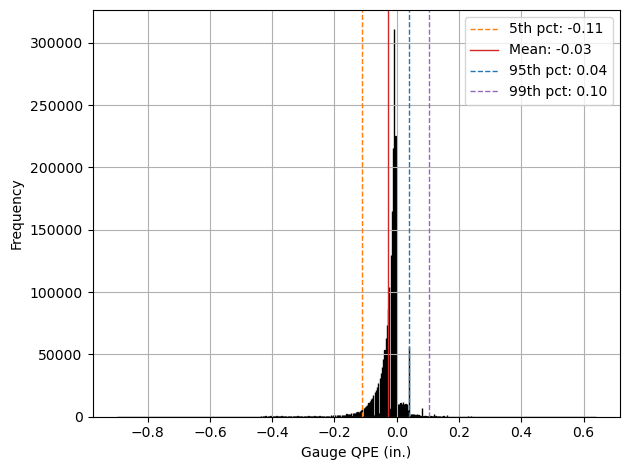

In [ ]:
data = df['delta_qpe']
mean = data.mean()
p5   = data.quantile(0.05)
p95  = data.quantile(0.95)
p99  = data.quantile(0.99)

fig, ax = plt.subplots()

ax.hist(data, bins="auto", edgecolor='black')
ax.axvline(p5,   ymin=0, ymax=1000, color='tab:orange', linestyle='--', linewidth=1, label=f'5th pct: {p5:.2f}')
ax.axvline(mean, color='tab:red',    linestyle='-',  linewidth=1, label=f'Mean: {mean:.2f}')
ax.axvline(p95,  color='tab:blue',  linestyle='--', linewidth=1, label=f'95th pct: {p95:.2f}')
ax.axvline(p99,  color='tab:purple',  linestyle='--', linewidth=1, label=f'99th pct: {p99:.2f}')

ax.set_xlabel("Gauge QPE (in.)")
ax.set_ylabel("Frequency")
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

### 3. Enviornmental Analysis

#### 3.1. Major Correlates of `delta_qpe`